# Generative Adversarial Network (GAN)

In dit notebook trainen we een GAN voor de MNIST dataset.

De code in dit voorbeeld is gebaseerd op de code uit hoofdstuk 4 van *Generative Deep Learning* van David Forester, O'Reilly Media, 2019 en op hoofdstuk 8 van *Deep Learning with Python* door François Chollet, Manning, 2018.

In [22]:
%matplotlib inline

from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout, ZeroPadding2D, UpSampling2D

from keras.models import Model, Sequential
from keras import backend as K
from keras.optimizers import Adam, RMSprop
from keras.utils import plot_model
from keras.initializers import RandomNormal

import numpy as np

We gebruiken 20-dimensional vectoren of afbeeldingen te genereren.

In [23]:
input_dim = (28,28,1)
z_dim = 20

### Discriminator

We maken eerst de discriminator. Deze krijgt als input een afbeelding en geeft als output of deze afbeelding echt is of niet.

In [28]:
discriminator_input = Input(shape=input_dim, name='discriminator_input')

x = Conv2D(64, kernel_size=5,
           strides=2,
           padding='same',
           name='discriminator_conv_1')(discriminator_input)
x = LeakyReLU()(x)
x = Dropout(rate=0.4)(x)

x = Conv2D(128, kernel_size=5,
           strides=2,
           padding='same',
           name='discriminator_conv_2')(x)
x = LeakyReLU()(x)
x = Dropout(rate=0.4)(x)

x = Conv2D(256, kernel_size=5,
           strides=2,
           padding='same',
           name='discriminator_conv_3')(x)
x = LeakyReLU()(x)
x = Dropout(rate=0.4)(x)

x = Conv2D(512, kernel_size=5,
           strides=1,
           padding='same',
           name='discriminator_conv_4')(x)
x = LeakyReLU()(x)
x = Dropout(rate=0.4)(x)

x = Flatten()(x)

discriminator_output = Dense(1, activation='sigmoid')(x)

discriminator = Model(discriminator_input, discriminator_output)

discriminator.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 discriminator_input (InputL  [(None, 28, 28, 1)]      0         
 ayer)                                                           
                                                                 
 discriminator_conv_1 (Conv2  (None, 14, 14, 64)       1664      
 D)                                                              
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 dropout_20 (Dropout)        (None, 14, 14, 64)        0         
                                                                 
 discriminator_conv_2 (Conv2  (None, 7, 7, 128)        204928    
 D)                                                              
                                                           

Wat valt je op aan het `discriminator` netwerk?

<b>

Wat me opvalt aan het discriminator netwerk is dat het een convolutioneel neuraal netwerk (CNN) is dat is opgebouwd uit meerdere Conv2D-lagen, en tussen elke Conv2D-laag is er een Dropuit-laag.

Compileer het `discriminator` netwerk.

In [29]:
discriminator_optimizer = RMSprop(
    learning_rate = 0.0008,
    clipvalue = 1.0,
    decay = 1e-8
)

discriminator.compile(optimizer = discriminator_optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

### Generator

De `generator` maakt van een random vector een afbeelding.

In [45]:
initial_dense_layer_size = (7, 7, 256)

generator_input = Input(shape = (z_dim,), name = 'generator_input')

x = Dense(np.prod(initial_dense_layer_size))(generator_input)
x = BatchNormalization(momentum = 0.9)(x)
x = Activation('relu')(x)
x = Reshape(initial_dense_layer_size)(x)

x = UpSampling2D()(x)
x = Conv2D(128 ,kernel_size = 5, padding = 'same', name = 'generator_conv_1')(x)
x = BatchNormalization(momentum = 0.9)(x)
x = Activation('relu')(x)

x = UpSampling2D()(x)
x = Conv2D(64 ,kernel_size = 5, padding = 'same', name = 'generator_conv_2')(x)
x = BatchNormalization(momentum = 0.9)(x)
x = Activation('relu')(x)

x = Conv2D(32, kernel_size = 5, padding = 'same', name = 'generator_conv_3')(x)
x = BatchNormalization(momentum = 0.9)(x)
x = Activation('relu')(x)

x = Conv2D(1, kernel_size = 5, padding = 'same', name = 'generator_conv_4')(x)

generator_output = Activation('tanh')(x)

generator = Model(generator_input, generator_output)

generator.summary()

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 generator_input (InputLayer  [(None, 20)]             0         
 )                                                               
                                                                 
 dense_17 (Dense)            (None, 12544)             263424    
                                                                 
 batch_normalization_44 (Bat  (None, 12544)            50176     
 chNormalization)                                                
                                                                 
 activation_55 (Activation)  (None, 12544)             0         
                                                                 
 reshape_11 (Reshape)        (None, 7, 7, 256)         0         
                                                                 
 up_sampling2d_25 (UpSamplin  (None, 14, 14, 256)      0  

Wat valt je op aan dit netwerk?

<b>

Wat me opvalt aan het generator netwerk is dat het een omgekeerde structuur heeft ten opzichte van het discriminator netwerk

### Adversarial Network

Het volledige Adversarial Network combineert de `generator` en de `discriminator`. Voordat we het model compileren, geven we aan dat de parameters van de `discriminator` in dit geval niet mogen veranderen. Anders zou de `discriminator` simpelweg alle afbeeldingen als echt bestempelen.

In [46]:
discriminator.trainable = False

gan_input = Input(shape = (z_dim,))
gan_output = discriminator(generator(gan_input))

gan = Model(gan_input, gan_output)

gan_optimizer = RMSprop(lr = 0.0004, clipvalue = 1.0, decay = 1e-8)

gan.compile(optimizer = gan_optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

discriminator.trainable = True

### Verover de data

In [47]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
    
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

### Trainen van een GAN

Let op: dit vereist heel veel geduld en een snelle computer, liefst met een GPU.
Probeer een paar iteraties te runnen.

1/1 [==============================] - 1s 710ms/step
discriminator loss: 0.7582736611366272 ,acc: 0.0
	discriminator loss (real): 0.6919856071472168 , acc (real:) 0.0
	discriminator loss (fake): 0.6919856071472168 , acc (fake:) 0.0
adversarial loss: 1.5903582572937012 , acc: 0.0


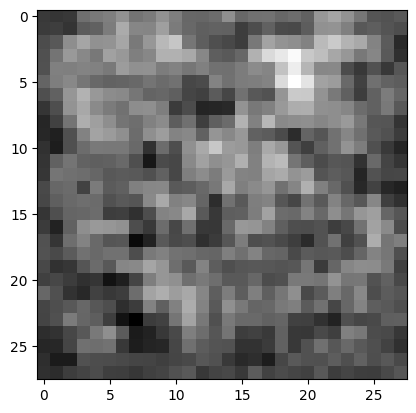

1/1 [==============================] - 1s 539ms/step
discriminator loss: 0.5619533360004425 ,acc: 0.0
	discriminator loss (real): 1.6707525253295898 , acc (real:) 0.0
	discriminator loss (fake): 1.6707525253295898 , acc (fake:) 0.0
adversarial loss: 16.381013870239258 , acc: 0.0


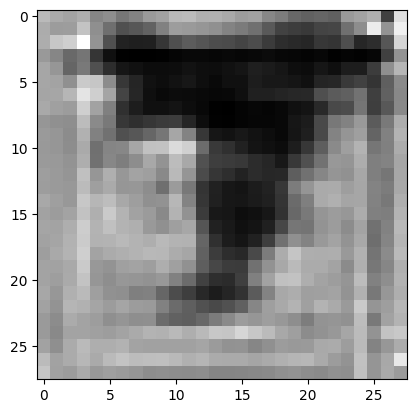

1/1 [==============================] - 1s 536ms/step
discriminator loss: 2.4149366319179535 ,acc: 0.0
	discriminator loss (real): 5.46536922454834 , acc (real:) 0.0
	discriminator loss (fake): 5.46536922454834 , acc (fake:) 0.0
adversarial loss: 43.04088592529297 , acc: 0.0


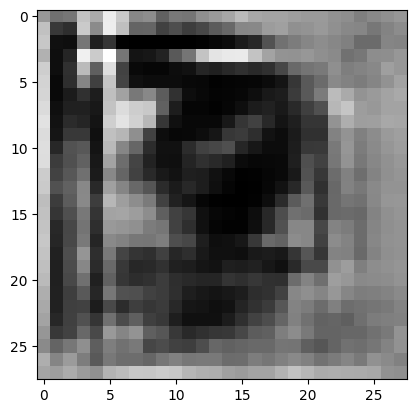

1/1 [==============================] - 1s 548ms/step
discriminator loss: -0.04035066068172455 ,acc: 0.0
	discriminator loss (real): 0.23190033435821533 , acc (real:) 0.0
	discriminator loss (fake): 0.23190033435821533 , acc (fake:) 0.0
adversarial loss: 20.482620239257812 , acc: 0.0


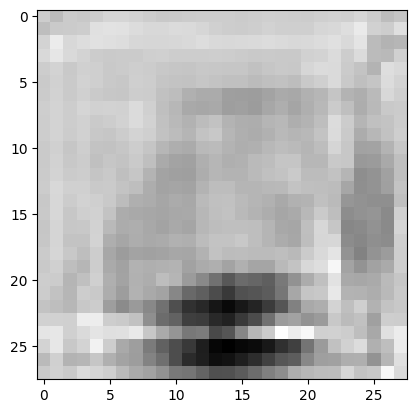

1/1 [==============================] - 1s 560ms/step
discriminator loss: 0.864351361989975 ,acc: 0.0
	discriminator loss (real): 0.8278167843818665 , acc (real:) 0.0
	discriminator loss (fake): 0.8278167843818665 , acc (fake:) 0.0
adversarial loss: 7.3584489822387695 , acc: 0.05000000074505806


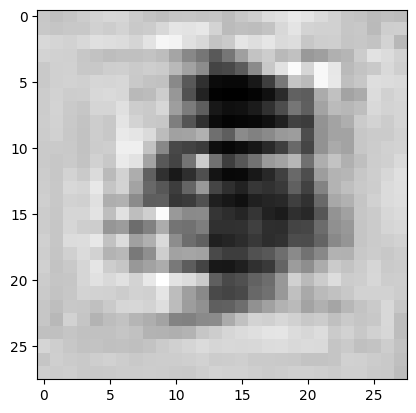

1/1 [==============================] - 1s 570ms/step
discriminator loss: -0.05020745098590851 ,acc: 0.0
	discriminator loss (real): 0.1961568295955658 , acc (real:) 0.0
	discriminator loss (fake): 0.1961568295955658 , acc (fake:) 0.0
adversarial loss: 18.865982055664062 , acc: 0.05000000074505806


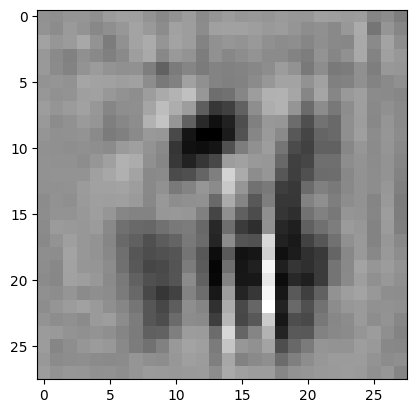

1/1 [==============================] - 1s 609ms/step
discriminator loss: 0.2954821363091469 ,acc: 0.0
	discriminator loss (real): 0.43168506026268005 , acc (real:) 0.0
	discriminator loss (fake): 0.43168506026268005 , acc (fake:) 0.0
adversarial loss: 13.045193672180176 , acc: 0.0


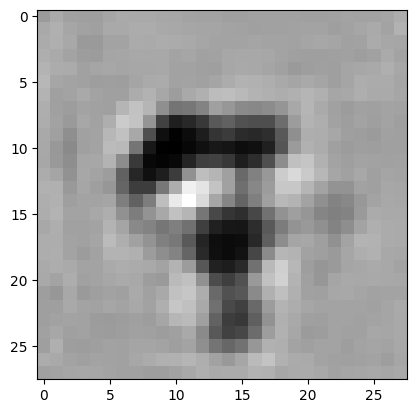

1/1 [==============================] - 1s 610ms/step
discriminator loss: -0.02212616056203842 ,acc: 0.0
	discriminator loss (real): 0.14101238548755646 , acc (real:) 0.0
	discriminator loss (fake): 0.14101238548755646 , acc (fake:) 0.0
adversarial loss: 21.14434814453125 , acc: 0.0


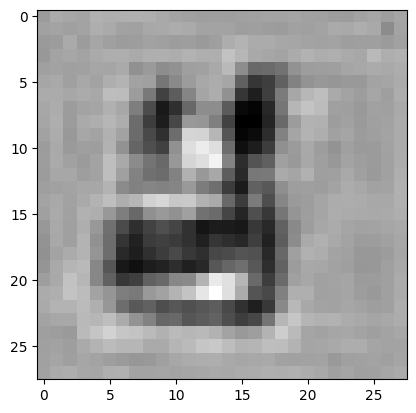

1/1 [==============================] - 1s 612ms/step
discriminator loss: 0.7042172253131866 ,acc: 0.0
	discriminator loss (real): 0.9261606335639954 , acc (real:) 0.0
	discriminator loss (fake): 0.9261606335639954 , acc (fake:) 0.0
adversarial loss: 21.913543701171875 , acc: 0.0


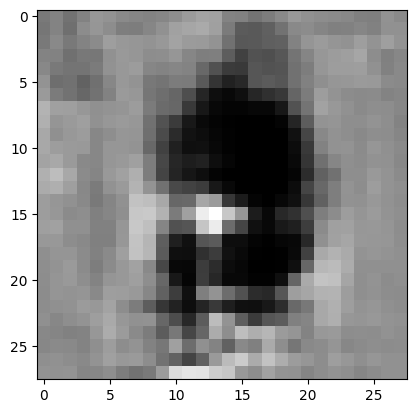

1/1 [==============================] - 1s 589ms/step
discriminator loss: 0.5332508906722069 ,acc: 0.0
	discriminator loss (real): 0.9055768847465515 , acc (real:) 0.0
	discriminator loss (fake): 0.9055768847465515 , acc (fake:) 0.0
adversarial loss: 11.734996795654297 , acc: 0.0


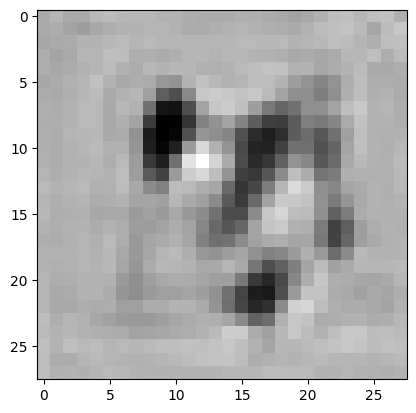

1/1 [==============================] - 1s 677ms/step


In [48]:
import matplotlib.pyplot as plt

iterations = 1000
batch_size = 20

start = 0
for step in range(iterations):
    stop = start + batch_size
    
    # genereer afbeeldingen
    random_latent_vectors = np.random.normal(size = (batch_size, z_dim))
    generated_images = generator.predict(random_latent_vectors)
    
    fake = np.ones((batch_size, 1))
    fake += 0.05 * np.random.random(fake.shape) # voeg een beetje ruis toe aan de labels
    
    # selecteer echte afbeeldingen
    real_images = x_train[start: stop]
    valid =  np.zeros((batch_size, 1))
    valid += 0.05 * np.random.random(valid.shape) # voeg een beetje ruis toe aan de labels 
    
    # train de discriminator
    d_loss_real, d_acc_real = discriminator.train_on_batch(real_images, valid)
    d_loss_fake, d_acc_fake = discriminator.train_on_batch(generated_images, fake)
    d_loss = 0.5 * (d_loss_real + d_loss_fake)
    d_acc = 0.5 * (d_acc_real + d_acc_fake)
    
    # nieuwe willekeurige vectoren
    random_latent_vectors = np.random.normal(size = (batch_size, z_dim))
    
    # geef deze allemaal het label 'echt' (maar dat zijn ze niet)
    misleading = np.zeros((batch_size, 1))
    
    # train de gewichten van de generator door het trainen van de gan als geheel
    a_loss, a_acc = gan.train_on_batch(random_latent_vectors, misleading)
    
    start += batch_size
    if start > len(x_train) - batch_size:
        start = 0
        
    if step % 100 == 0:        
        print('discriminator loss:', d_loss, ',acc:', d_acc)
        print('\tdiscriminator loss (real):', d_loss_real, ', acc (real:)', d_acc_real)
        print('\tdiscriminator loss (fake):', d_loss_real, ', acc (fake:)', d_acc_real)
        print('adversarial loss:', a_loss, ', acc:', a_acc)
        
        img = generated_images[0].reshape((28,28))
        plt.imshow(img, cmap='gray_r')
        plt.show()

Bonus: mocht je in de gelukkige omstandigheden zijn dat het lukt om het model te trainen, varieer dan eens de stuctuur van de generator en de discriminator.

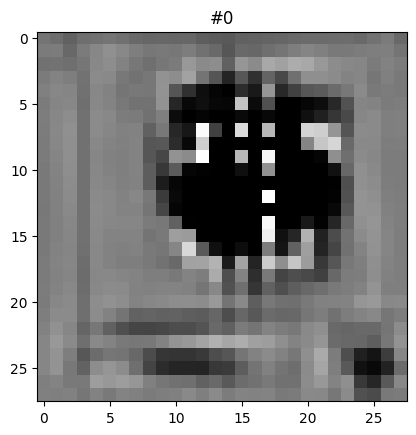

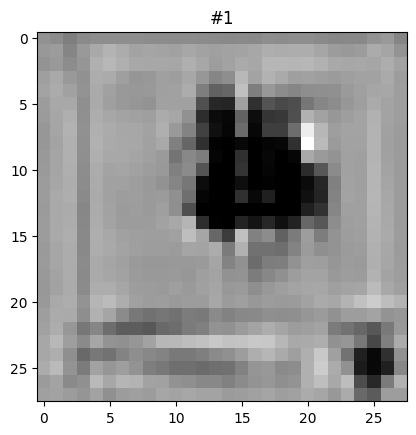

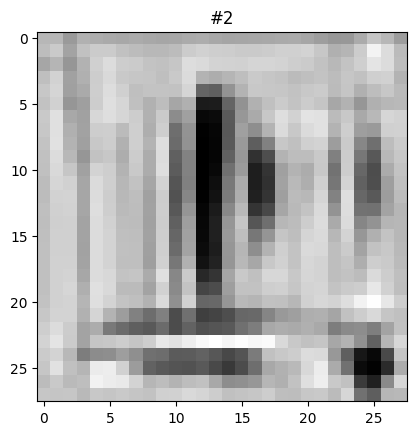

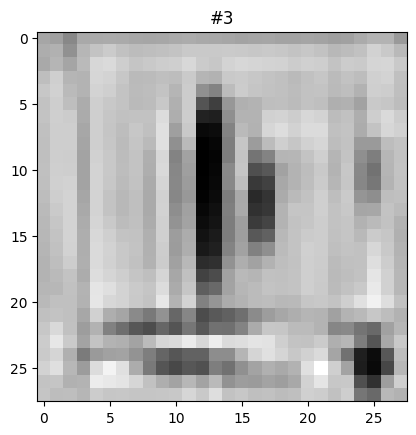

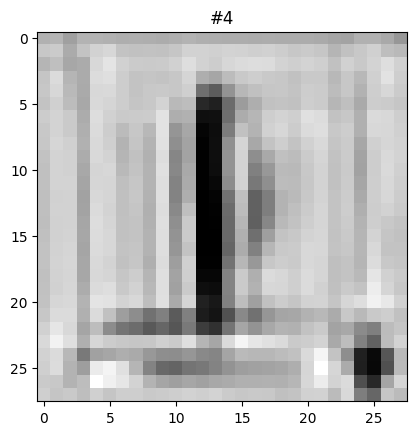

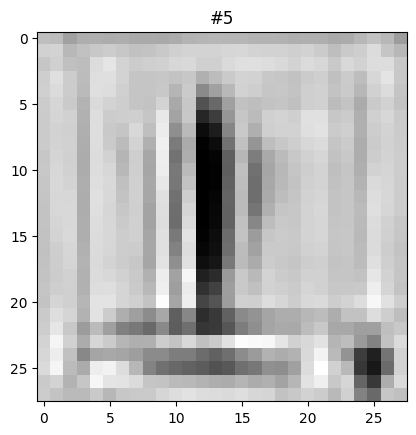

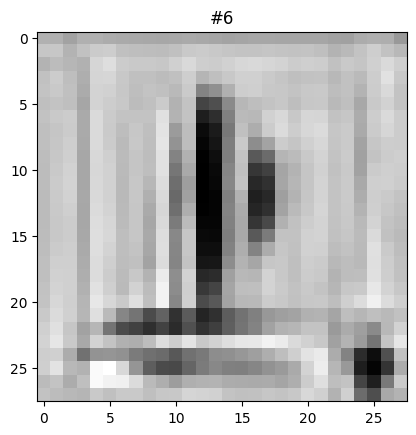

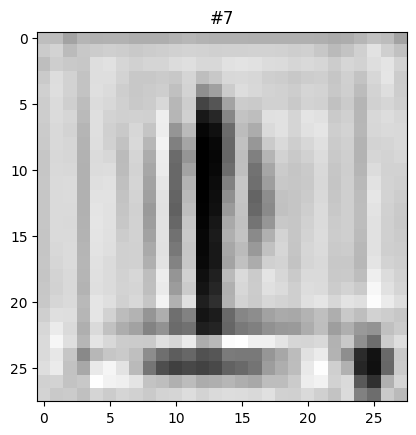

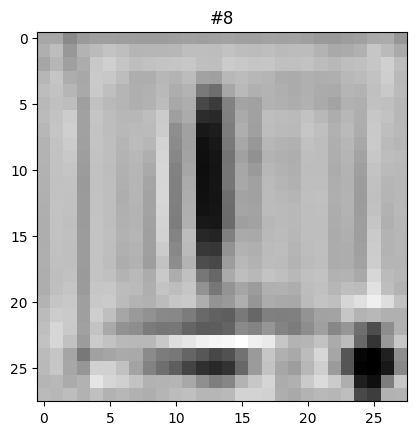

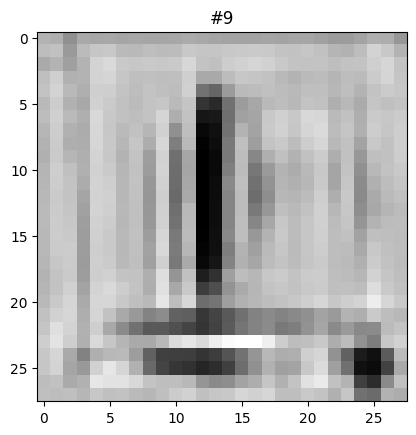

In [ ]:
for im in range(10):
    img = generated_images[im].reshape((28,28))
    plt.title("#" + str(im))
    plt.imshow(img, cmap='gray_r')
    plt.show()

<b>

`Bewering voor de verbeteringen`

De huidige GAN levert slecht resultaten op. Dus ik zal de discriminator en generator verbteren door bijv. meer Conv2D-lagen toe te voegen, het aantal filters in elke Conv2D-laag enz..

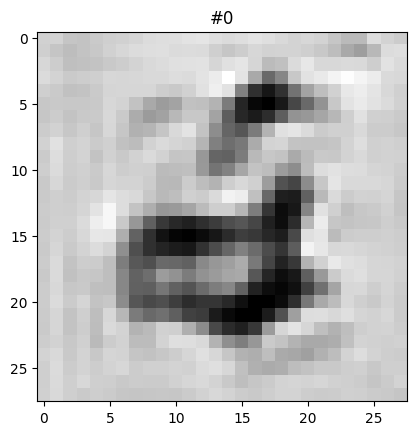

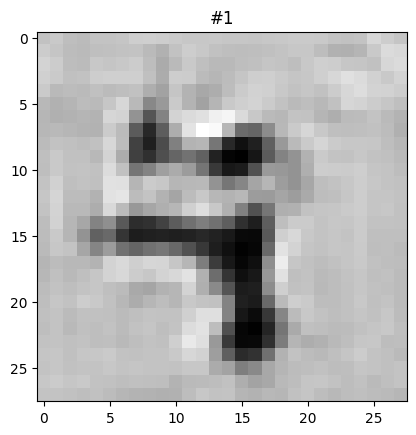

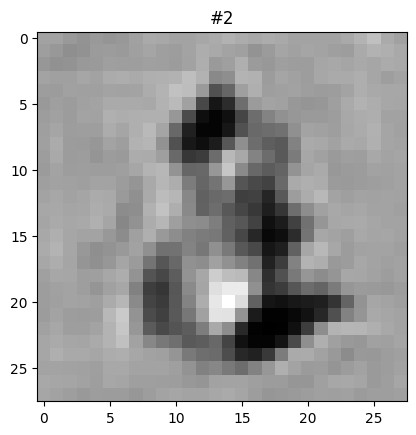

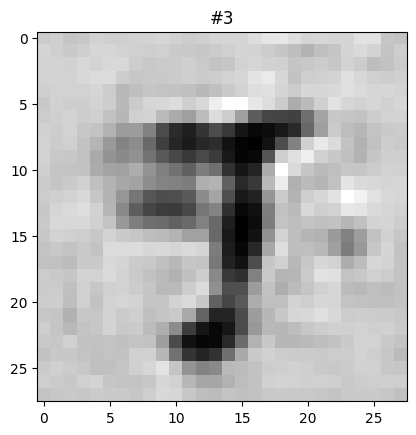

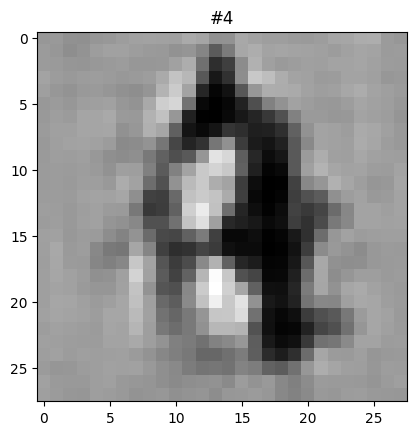

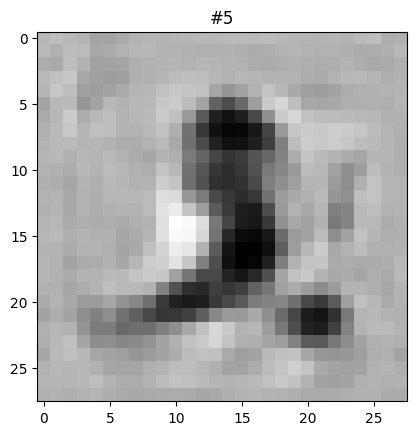

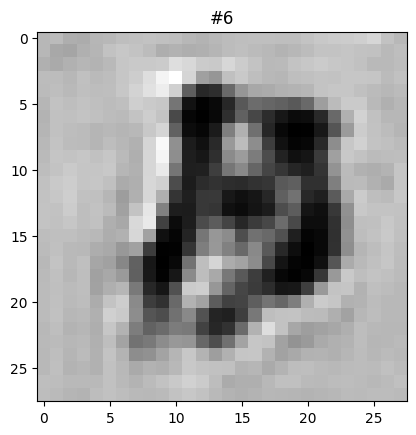

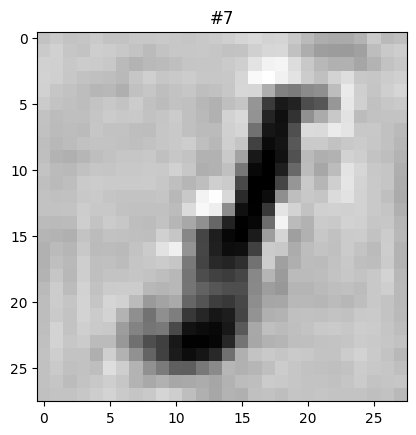

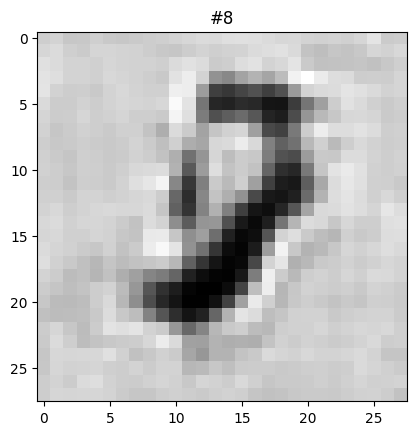

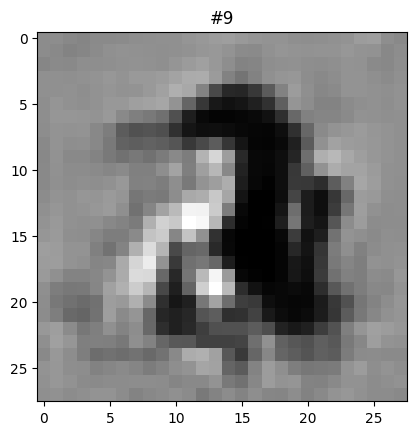

In [49]:
for im in range(10):
    img = generated_images[im].reshape((28,28))
    plt.title("#" + str(im))
    plt.imshow(img, cmap='gray_r')
    plt.show()

<b>

Na de verbeteringen kunnen we zien dat het de goede kant op gaat. Helaas ga ik hier stoppen, want mijn laptop is niet zeer geschickt voor zulke zware taken.